In [81]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
from matplotlib.ticker import MultipleLocator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
%matplotlib inline

In [82]:
path = os.getcwd().split('TianChi_IJCAI-17_footfall_prediction_code')[0]

#shop_info = pd.read_table(path+'dataset/shop_info.txt',names=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name'],header=None,delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info = pd.read_table(path+'dataset/shop info with count.csv',delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)

shop_info.index = shop_info['shop_id'].tolist()

In [83]:
def dateRange(start, end):
    days = (datetime.datetime.strptime(end, "%Y-%m-%d") - datetime.datetime.strptime(start, "%Y-%m-%d")).days + 1
    return [datetime.datetime.strftime(datetime.datetime.strptime(start, "%Y-%m-%d") + datetime.timedelta(i), "%Y-%m-%d") for i in xrange(days)]
#len(dateRange('2015-07-01','2016-10-31'))
#占个格子
for day_number in range(1,15): #1～14
    predict_day_col = 'predict_day_'+str(day_number)
    shop_info[predict_day_col] = 0 

start_day = (pd.to_datetime('2016-11-01').date() - datetime.timedelta(21)).strftime("%Y-%m-%d")
for day_number in range(1,15):
    predict_day = '2016-11-'+'%02d' %  day_number
    predict_day = pd.to_datetime(predict_day).date()
    print 'predict_day=',predict_day
    day_list = [day for day in dateRange(start_day,'2016-10-31') if (predict_day - pd.to_datetime(day).date()).days % 7 == 0]
    print shop_info['predict_day_'+str(day_number)]
    

### 实现基本预处理 步长为3的取中值

for id in shop_info.index.tolist():
    for day in dateRange('2016-10-09','2016-10-30'):
        day_before = (pd.to_datetime(day).date() - datetime.timedelta(1)).strftime("%Y-%m-%d")
        day_after = (pd.to_datetime(day).date() + datetime.timedelta(1)).strftime("%Y-%m-%d")
        threedays = [shop_info.loc[id,day],shop_info.loc[id,day_before],shop_info.loc[id,day_after]]
        threedays = np.array(threedays)
        shop_info.loc[id,day] = np.int64(np.median(threedays))
    if id % 100 == 0:
        print id

### 基本与处理 填充最后三周单次出现的零值

In [84]:
ids_zero_1_count_in_last_three_week = [513, 987, 1163, 524, 397, 18, 1556, 1688, 5, 1185, 1700, 1959, 683, 1715, 958, 480, 707, 459, 1486, 1831, 722, 735, 352, 363, 1661, 1918]
for day in dateRange('2016-10-11','2016-10-31'):
    for id in ids_zero_1_count_in_last_three_week:
        if shop_info.loc[id,day] == 0:
            day_offset = (pd.to_datetime(day).date() - datetime.date(2016,10,11)).days % 7 
            rel_days = []
            for rel_day in dateRange('2016-10-11','2016-10-31'):
                if (pd.to_datetime(rel_day).date() - datetime.date(2016,10,11)).days % 7 == day_offset and rel_day != day:
                    rel_days.append(shop_info.loc[id,rel_day])
            rel_days = np.array(rel_days)
            shop_info.loc[id,day] = np.int64(rel_days.mean()+0.5)

### 预测值低位boost

In [90]:
def prediction_low_boost():
    predictday = ['predict_day_'+str(i) for i in range(1,15)]
    for id in shop_info.index.tolist():
        
        result = sorted(shop_info.loc[id,'predict_day_1':'predict_day_14'].tolist()) #从低到高 0~13
        if float(result[12]+result[13]-result[0]+result[0])/(result[12]+result[13]) >  0.5:
            for day in predictday:
                if 2.0*shop_info.loc[id,day] / (result[12]+result[13]) < 0.5:#boost
                    shop_info.loc[id,day] += np.int64(((result[12]+result[13])/2.0 - shop_info.loc[id,day]) * 0.08+0.5)


## cal_day_of_week_avg_in_n_days(n)    同星期几算术均值法

In [85]:
def cal_day_of_week_avg_in_n_days(n,return_int = True):
    start_day = (pd.to_datetime('2016-11-01').date() - datetime.timedelta(n)).strftime("%Y-%m-%d")
    print 'start day = ',start_day
    for day_number in range(1,15): # 1~14
        predict_day_col = 'predict_day_'+str(day_number) 
        predict_day = '2016-11-'+'%02d' %  day_number
        predict_day = pd.to_datetime(predict_day).date()
        day_list = [day for day in dateRange(start_day,'2016-10-31') if (predict_day - pd.to_datetime(day).date()).days % 7 == 0]
        shop_info['predict_day_'+str(day_number)] = shop_info[day_list].mean(axis=1)
        if return_int:
            shop_info['predict_day_'+str(day_number)] = shop_info['predict_day_'+str(day_number)].apply(lambda x: int(x+0.5))
           

### cal_day_of_week_avg_in_n_days(21)

In [86]:
cal_day_of_week_avg_in_n_days(21)

start day =  2016-10-11


In [78]:
shop_info.head()

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name,...,predict_day_5,predict_day_6,predict_day_7,predict_day_8,predict_day_9,predict_day_10,predict_day_11,predict_day_12,predict_day_13,predict_day_14
1,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点,...,239,263,201,251,196,220,244,239,263,201
2,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN,...,84,86,53,27,32,28,52,84,86,53
3,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶,...,116,109,63,69,65,71,92,116,109,63
4,4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN,...,197,206,95,89,110,62,104,197,206,95
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果,...,183,247,322,242,143,226,199,183,247,322


In [ ]:
#shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction (day of week average in 21 days).csv',sep=',',index=True,columns=None)

#### cal_day_of_week_avg_in_n_days(21) but do special process

for i in range(1,15):
    shop_info.loc[1824,'predict_day_'+str(i)] = shop_info.loc[1824,'2016-08-23':'2016-09-05'].tolist()[i-1]
print shop_info.loc[1824,'predict_day_1':'predict_day_14']

In [25]:
#shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction (day of week average in 21 days)(special_1824_A).csv',sep=',',index=True,columns=None)

In [70]:
#shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction (day of week average in 21 days)(special_1824_A)(median_3_filter).csv',sep=',',index=True,columns=None)

In [80]:
#shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction (day of week average in 21 days)(special_1824_A)(fill singer zero point).csv',sep=',',index=True,columns=None)

In [92]:
#prediction_low_boost()

In [93]:
#shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction (day of week average in 21 days)(special_1824_A)(fill singer zero point)(low boost).csv',sep=',',index=True,columns=None)

In [55]:
day_list = np.array(shop_info.loc[1824,'2016-08-23':'2016-10-03'].tolist())
for i in range(1,15):
    shop_info.loc[1824,'predict_day_'+str(i)] = int(day_list[range((i-1) % 7,42,7)].mean()+0.5)
print shop_info.loc[1824,'predict_day_1':'predict_day_14']

predict_day_1     56
predict_day_2     58
predict_day_3     53
predict_day_4     65
predict_day_5     55
predict_day_6     57
predict_day_7     43
predict_day_8     56
predict_day_9     58
predict_day_10    53
predict_day_11    65
predict_day_12    55
predict_day_13    57
predict_day_14    43
Name: 1824, dtype: object


In [58]:
#shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction (day of week average in 21 days)(special_1824_B).csv',sep=',',index=True,columns=None)

### cal_day_of_week_avg_in_n_days(14)

In [42]:
cal_day_of_week_avg_in_n_days(14)

2016-10-18


In [ ]:
#shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction (day of week average in 14 days).csv',sep=',',index=True,columns=None)

##  cal_day_of_week_avg_add_optimal_offset_in_n_days(n)    均值加上optimal score n 天 line 与 avg line 的 offset

In [230]:
def cal_optimal_score_function_count_n_days_sub(n,x):
    start_date = (pd.to_datetime('2016-10-31').date()-datetime.timedelta(days=(n-1))).strftime("%Y-%m-%d")
    M = [float(i) for i in x[start_date:'2016-10-31'].tolist()] 
    best_score = np.inf
    best_count = 0
    for possible_count in np.arange(min(M),max(M)+1) :
        #print possible_count
        score = np.sum(np.fabs((possible_count-M)/(possible_count+M))) / len(M)
        #print 'score',score,'best_score',best_score,'possible_count',possible_count
        if score < best_score:
            best_score = score
            best_count = possible_count
            
    return best_count
  
    
def cal_optimal_score_function_count_n_days(n):
    shop_info['count_optimal_score_'+str(n)+'_days'] = shop_info.apply(lambda x:cal_optimal_score_function_count_n_days_sub(n,x) ,axis=1)    

def cal_total_count_avg_n_days(x,n):
    spe_day = pd.to_datetime('2016-10-31').date() - datetime.timedelta(days=(n-1))
    start_day = ''
    for day in dateRange('2015-07-01','2016-10-31'):
        if x[day]>0:
            start_day = day
            #print start_day
            break
    #print 'spe_day=',spe_day
    if pd.to_datetime(start_day).date() < spe_day:
        start_day=spe_day.strftime("%Y-%m-%d")
    #print start_day
    return float(x[start_day:'2016-10-31'].sum()) /  n
            
def get_total_count_avg_n_days(n):
    shop_info['total_count_avg_'+str(n)+'_days'] = shop_info.apply(lambda x: cal_total_count_avg_n_days(x,n),axis=1)


In [252]:
def cal_day_of_week_avg_add_optimal_offset_in_n_days(n):
    cal_day_of_week_avg_in_n_days(n,return_int=False)
    cal_optimal_score_function_count_n_days(n)
    get_total_count_avg_n_days(n)
    shop_info['diff_between_optimal_and_count_avg'] = shop_info['count_optimal_score_'+str(n)+'_days']-shop_info['total_count_avg_'+str(n)+'_days']
    for day in range(1,15):#1~14
        shop_info.loc[:,'predict_day_'+str(day)] += shop_info['diff_between_optimal_and_count_avg']
        shop_info['predict_day_'+str(day)] = shop_info['predict_day_'+str(day)].apply(lambda x: int(x+0.5) if x > 0 else 0)

In [254]:
cal_day_of_week_avg_add_optimal_offset_in_n_days(21)
shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction(day_of_week_avg_add_optimal_offset_in_21_days).csv',sep=',',index=True,columns=None)   

start day =  2016-10-11


##  cal_day_of_week_avg_add_optimal_offset_avg_1to21_day()    均值加上optimal score line(1~21均值) 与 avg line 的 offset

In [253]:
def cal_day_of_week_avg_add_optimal_offset_avg_1to21_day():
    cal_day_of_week_avg_in_n_days(21,return_int=False)
    get_total_count_avg_n_days(21)
    for i in range(1,21+1):
        cal_optimal_score_function_count_n_days(i)
    avg_1_to_21_days_cols = ['count_optimal_score_'+ str(i) +'_days' for i in range(1,21+1)]
    shop_info['optimal_count_avg_1_to_21_days'] = shop_info.apply(lambda x: x.loc[avg_1_to_21_days_cols].mean() , axis = 1)
    shop_info['diff_between_optimal_and_count_avg'] = shop_info['optimal_count_avg_1_to_21_days']-shop_info['total_count_avg_21_days']
    for day in range(1,15):#1~14
        shop_info.loc[:,'predict_day_'+str(day)] += shop_info['diff_between_optimal_and_count_avg']
        shop_info['predict_day_'+str(day)] = shop_info['predict_day_'+str(day)].apply(lambda x: int(x+0.5) if x > 0 else 0)

In [255]:
cal_day_of_week_avg_add_optimal_offset_avg_1to21_day()
shop_info.loc[:,'predict_day_1':'predict_day_14'].to_csv('Prediction(day_of_week_avg_add_optimal_offset_avg_1to21_day).csv',sep=',',index=True,columns=None)   

start day =  2016-10-11


In [251]:
shop_info.head()

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name,...,count_optimal_score_12_days,count_optimal_score_13_days,count_optimal_score_14_days,count_optimal_score_15_days,count_optimal_score_16_days,count_optimal_score_17_days,count_optimal_score_18_days,count_optimal_score_19_days,count_optimal_score_20_days,optimal_count_avg_1_to_21_days
1,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点,...,230.0,226.0,230.0,226.0,230.0,230.0,243.0,230.0,239.0,233.857143
2,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN,...,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,93.857143
3,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶,...,102.0,88.0,88.0,80.0,88.0,88.0,88.0,80.0,75.0,87.000000
4,4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN,...,104.0,110.0,104.0,104.0,104.0,110.0,110.0,110.0,110.0,113.619048
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果,...,221.0,221.0,215.0,221.0,215.0,215.0,211.0,215.0,215.0,225.000000


In [248]:
shop_info.head()

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name,...,predict_day_8,predict_day_9,predict_day_10,predict_day_11,predict_day_12,predict_day_13,predict_day_14,count_optimal_score_21_days,total_count_avg_21_days,diff_between_optimal_and_count_avg
1,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点,...,259,204,229,252,247,271,209,239.0,230.523810,8.476190
2,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN,...,72,77,72,97,128,130,97,96.0,51.714286,44.285714
3,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶,...,60,56,62,84,107,100,54,75.0,83.523810,-8.523810
4,4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN,...,76,97,49,91,184,193,82,110.0,123.047619,-13.047619
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果,...,248,149,156,205,189,253,328,218.0,212.428571,5.571429
6,6,大连,1139,13,3.0,1.0,0,美食,烘焙糕点,面包,...,96,100,101,122,105,112,93,104.0,102.380952,1.619048
7,7,绍兴,145,13,3.0,9.0,2,美食,快餐,西式快餐,...,115,94,111,127,160,183,107,128.0,134.714286,-6.714286
8,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果,...,67,63,71,49,81,88,57,68.0,67.190476,0.809524
9,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,NaN,...,194,193,210,192,243,281,226,220.0,230.904762,-10.904762
10,10,孝感,98,10,NaN,NaN,0,超市便利店,超市,NaN,...,89,119,81,83,87,101,90,93.0,95.333333,-2.333333


##  cal_day_of_week_avg_add_optimal_offset_in_n_days(n)    几何均值加上optimal score line 与 avg line 的 offset

##  cal_day_of_week_avg_add_optimal_offset_in_n_days(n)    反调和均值均值加上optimal score line 与 avg line 的 offset

## 可视化

In [47]:
# to check whether the columns is right
shop_info.columns.tolist()[-30:]

[u'2016-10-16',
 u'2016-10-17',
 u'2016-10-18',
 u'2016-10-19',
 u'2016-10-20',
 u'2016-10-21',
 u'2016-10-22',
 u'2016-10-23',
 u'2016-10-24',
 u'2016-10-25',
 u'2016-10-26',
 u'2016-10-27',
 u'2016-10-28',
 u'2016-10-29',
 u'2016-10-30',
 u'2016-10-31',
 'predict_day_1',
 'predict_day_2',
 'predict_day_3',
 'predict_day_4',
 'predict_day_5',
 'predict_day_6',
 'predict_day_7',
 'predict_day_8',
 'predict_day_9',
 'predict_day_10',
 'predict_day_11',
 'predict_day_12',
 'predict_day_13',
 'predict_day_14']

In [84]:
def draw_ids(ids,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[ids,start_date:end_date].T.plot(figsize=figsize)

In [49]:
def draw_id(id,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[id,start_date:end_date].plot(legend=True,figsize=figsize)
    

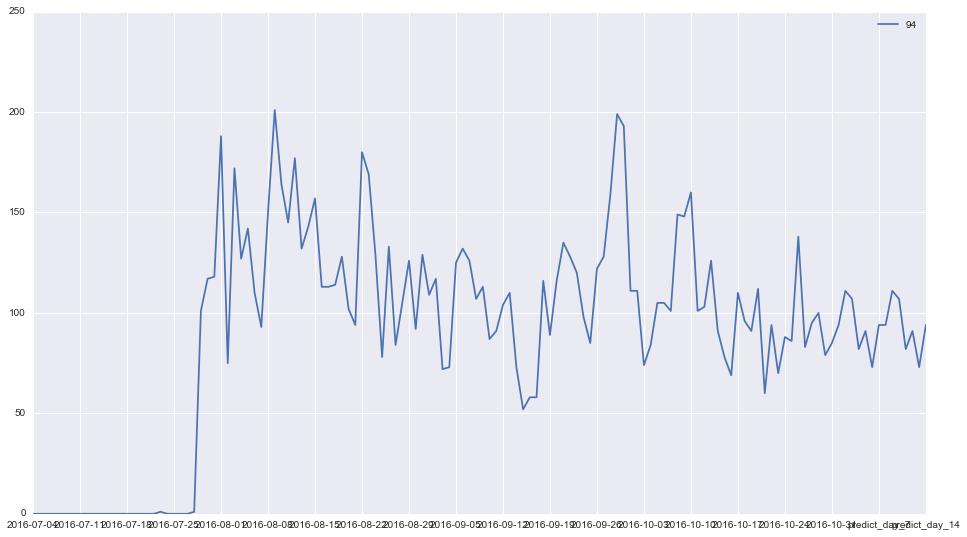

In [215]:
#id= 23
draw_id(id,start_date='2016-07-04',end_date='predict_day_14',by_week=True)
id+=1

In [226]:
shop_info

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name,...,predict_day_5,predict_day_6,predict_day_7,predict_day_8,predict_day_9,predict_day_10,predict_day_11,predict_day_12,predict_day_13,predict_day_14
1,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点,...,239,263,201,251,196,220,244,239,263,201
2,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN,...,84,86,53,27,32,28,52,84,86,53
3,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶,...,116,109,63,69,65,71,92,116,109,63
4,4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN,...,197,206,95,89,110,62,104,197,206,95
5,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果,...,183,247,322,242,143,150,199,183,247,322
6,6,大连,1139,13,3.0,1.0,0,美食,烘焙糕点,面包,...,103,110,91,95,98,99,120,103,110,91
7,7,绍兴,145,13,3.0,9.0,2,美食,快餐,西式快餐,...,167,190,113,122,101,117,133,167,190,113
8,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果,...,80,87,56,67,62,70,48,80,87,56
9,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,NaN,...,254,292,237,205,204,221,203,254,292,237
10,10,孝感,98,10,NaN,NaN,0,超市便利店,超市,NaN,...,89,104,92,92,121,84,86,89,104,92
